In [1]:
import maped as maped

from datetime import datetime,timedelta

### date

In [2]:
# Time string in "YYYY-MM-DD HH:MM" or "YYYY-MM-DD HH:MM:SS.SS" format
date_str = "2025-10-06 00:00:00"
# # ut_offset (float): Hours offset from UTC. Positive for East of Greenwich, negative for West.
# ut_offset = -3

### site

In [3]:
MPC_OBSERVATORY_CODE = 'Y28'
# Observatory data 
MPC_CODES_FILE = 'C:/Users/michi/OneDrive/Escritorio/phase_curves_project/MPC_observatory_codes/MPC_OBS_CODES.csv'
site_longitude_360, site_latitude, site_elevation_m = maped.get_observatory_coordinates(MPC_CODES_FILE, MPC_OBSERVATORY_CODE)
# Convert 0-360 E to -180 to +180 E
site_longitude = site_longitude_360
if site_longitude > 180.0:
    site_longitude = site_longitude - 360.0 # site_longitude will be -155.4683
# The latitude of the site: Observer's latitude (phi) in degrees. North is positive. (float, degrees)

print(f"Observatory {MPC_OBSERVATORY_CODE}: {site_latitude:.4f}°N, {site_longitude:.4f}°E, {site_elevation_m}m")

Observatory Y28: -8.7887°N, -38.6874°E, 414.679m


In [4]:
from tzfpy import get_tz
import pytz
from datetime import datetime

def get_utc_offset_from_coords(lat, lon):
    """
    Get UTC offset from latitude and longitude using tzfpy
    
    Args:
        lat: Latitude (float)
        lon: Longitude (float)
        
    Returns:
        tuple: (offset_hours, timezone_name) or (None, None) if failed
    """
    try:
        # Get timezone name from coordinates
        tz_name = get_tz(lon, lat)  # Note: tzfpy uses (lon, lat) order
        
        if tz_name is None:
            print("Could not find timezone for these coordinates")
            return None, None
        
        # Get the timezone object
        tz = pytz.timezone(tz_name)
        
        # Get current UTC offset (including DST if applicable)
        now = datetime.now(tz)
        offset = now.utcoffset().total_seconds() / 3600
        
        return offset, tz_name
        
    except Exception as e:
        print(f"Error: {e}")
        return None, None

In [7]:
ut_offset, tz_name = get_utc_offset_from_coords(site_latitude, site_longitude)
print(f"UTC Offset: {ut_offset:+.1f} hours")

UTC Offset: -3.0 hours


### calculate evening and morning events 

In [8]:
# --- 1. Get Evening Events (Sunset & Dusk for the starting date) ---
sunrise_1, sunset_1, dawn_1, dusk_1 = maped.calculate_events_for_date(
    date_str, site_longitude_360, site_latitude, ut_offset, site_elevation_m
)

# From the string of the starting date (date_str) get the string for the next day (date_str_2)
date_str_object = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
date_str_2_object = date_str_object + timedelta(days=1)
date_str_2 = date_str_2_object.strftime("%Y-%m-%d %H:%M:%S")


# --- 2. Get Morning Events (Dawn & Sunrise for the next day) ---
sunrise_2, sunset_2, dawn_2, dusk_2 = maped.calculate_events_for_date(
    date_str_2, site_longitude_360, site_latitude, ut_offset, site_elevation_m
)

In [9]:
# --- Final Observation Plan Summary ---
print(f"Observation Night: {date_str.split(' ')[0]} to {date_str_2.split(' ')[0]}")
print(f"Sunset: {maped.decimal_hours_to_time(sunset_1)}")
print(f"Astronomical Dusk: {maped.decimal_hours_to_time(dusk_1)}")
print(f"Astronomical Dawn (Next Day): {maped.decimal_hours_to_time(dawn_2)}")
print(f"Sunrise (Next Day): {maped.decimal_hours_to_time(sunrise_2)}")

Observation Night: 2025-10-06 to 2025-10-07
Sunset: 17:32:58.02
Astronomical Dusk: 18:40:04.50
Astronomical Dawn (Next Day): 04:06:21.70
Sunrise (Next Day): 05:13:31.62


In [20]:
ra_dec_str = "21 01 15.1 -12 22 42"


ra_hours, ra_deg, dec_deg, dec_rad = maped.parse_and_convert_ra_dec(ra_dec_str)

date_str_elevation_start_object = date_str_object + timedelta (hours=sunset_1) - timedelta (minutes=30)

date_str_elevation_start = date_str_elevation_start_object.strftime("%Y-%m-%d %H:%M:%S")

list_dates_objects = [date_str_elevation_start_object + timedelta(minutes=1*(i+1)) for i in range(1000)]
list_dates_str =  [i.strftime("%Y-%m-%d %H:%M:%S") for i in list_dates_objects]


list_dates_objects_modified = [i for i in list_dates_objects]


list_JDs = []
for i in list_dates_str:
    Y, M, D = maped.parse_date_to_YMD_flexible(i)
    list_JDs.append(maped.calculate_julian_day(Y, M, D))

list_GMST_degrees = [maped.calculate_mean_sidereal_time(i) for i in list_JDs]

list_LST = [maped.calculate_local_sidereal_time(i,site_longitude) for i in list_GMST_degrees]

list_H_hours = [i - ra_hours for i in list_LST]

list_altitude_degrees = [maped.calculate_object_altitude(site_latitude, dec_deg, i) for i in list_H_hours]

In [ ]:
list_dates_objects_modified,list_altitude_degrees

[datetime.datetime(2025, 10, 6, 15, 31, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 32, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 33, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 34, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 35, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 36, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 37, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 38, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 39, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 40, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 41, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 42, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 43, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 44, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 45, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 46, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 47, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 48, 31, 724749),
 datetime.datetime(2025, 10, 6, 15, 49, 31, 72

In [7]:
import numpy as np

def elevation_to_airmass(elevation_deg):
    """
    Calculates the airmass (approximately) from the elevation in degrees.
    Airmass is typically A = 1 / sin(elevation).
    """
    # Convert degrees to radians for the sine function
    elevation_rad = np.deg2rad(elevation_deg)
    
    # Handle the case where elevation is 0 to avoid division by zero
    if elevation_deg <= 0:
        return '---' # Or 'Inf' for theoretical infinity
        
    airmass = 1 / np.sin(elevation_rad)
    return airmass


def airmass_young_1994(elevation_deg):
    """
    Calculates the airmass (X) using the highly accurate formula by Young (1994).
    The formula uses the true zenith angle (zt) in terms of degrees.
    """
    # 1. Convert Elevation (alpha) to Zenith Angle (zt)
    # zt = 90 - alpha
    zt_deg = 90.0 - elevation_deg
    
    # Handle the case where the object is below the horizon (zt_deg >= 90)
    # The formula is unstable for zt near 90 or greater. 
    # For zt >= 89.9 (or elevation <= 0.1), use a large fixed value or an indicator.
    if zt_deg >= 89.9:
        return np.nan # Use NaN to filter out of display or return '---'
        
    # 2. Convert Zenith Angle to Radians for numpy.cos()
    zt_rad = np.deg2rad(zt_deg)
    
    # Calculate cos(zt)
    cos_zt = np.cos(zt_rad)
    
    # 3. Apply the Young (1994) formula:
    
    # Numerator
    numerator = (1.002432 * cos_zt**2) + (0.148386 * cos_zt) + 0.0096467
    
    # Denominator
    denominator = (cos_zt**3) + (0.149864 * cos_zt**2) + (0.0102963 * cos_zt) + 0.000303978
    
    airmass = numerator / denominator
    return airmass


def airmass_formatter(y, pos):
    """
    Custom formatter for the Airmass axis labels.
    y is the elevation value (in degrees) from the primary y-axis.
    """
    # Only calculate for positive elevation
    if y <= 0:
        return '---'
    
    airmass = airmass_young_1994(y)
    
    # Format the airmass value to two decimal places
    return f"{airmass:.2f}"

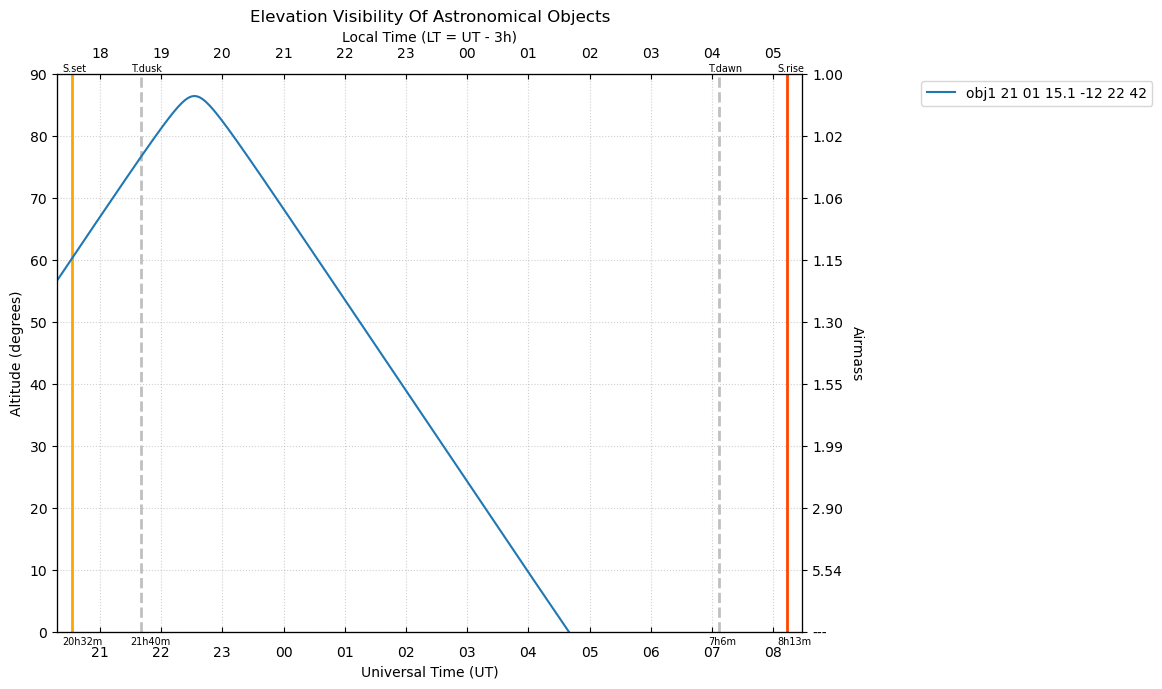

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter # Import FuncFormatter

# --- 1. Define the Time Data and UT Offset ---
# The UTC Offset (e.g., Local Time = UTC - 3 hours)
# NOTE: Using a hypothetical UT_OFFSET = -3 for this example.
# Ensure 'date_str', 'maped.decimal_hours_to_time', 'sunset_1', etc., are defined in your environment.
# UT_OFFSET = -3 # hours. Change this to your actual offset.

# Placeholder date for the 'current' day (Oct 2, 2025)
# Using a dummy date_str and time values for the purpose of a runnable example
# date_str = "2025-10-02 12:00:00"
today = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
tomorrow = today + timedelta(days=1)

# # Dummy implementation for required external functions/variables
# class Maped:
#     @staticmethod
#     def decimal_hours_to_time(h):
#         h_int = int(h)
#         m = int((h - h_int) * 60)
#         s = int(((h - h_int) * 60 - m) * 60)
#         return f"{h_int:02d}:{m:02d}:{s:02d}.00"

# maped = Maped()
# sunset_1 = 17.51
# dusk_1 = 18.67
# dawn_2 = 4.2
# sunrise_2 = 5.35

def parse_time(time_str, base_date):
    """Parses 'HH:MM:SS.ms' string and combines with a base date."""
    H, M, S = map(float, time_str.split(':'))
    seconds_int = int(S)
    microseconds = int((S - seconds_int) * 1000000)
    
    return base_date.replace(
        hour=int(H), 
        minute=int(M), 
        second=seconds_int, 
        microsecond=microseconds
    )

# 1a. Calculate Local Time (LT) data points
LT_SUNSET = parse_time(maped.decimal_hours_to_time(sunset_1), today)
LT_twilight_dusk = parse_time(maped.decimal_hours_to_time(dusk_1), today)
LT_twilight_dawn = parse_time(maped.decimal_hours_to_time(dawn_2), tomorrow)
LT_SUNRISE = parse_time(maped.decimal_hours_to_time(sunrise_2), tomorrow)

# 1b. ***CRUCIAL STEP: Convert LT events to UT events***
# UT = LT - UT_OFFSET
UT_SUNSET = LT_SUNSET - timedelta(hours=ut_offset)
UT_twilight_dusk = LT_twilight_dusk - timedelta(hours=ut_offset)
UT_twilight_dawn = LT_twilight_dawn - timedelta(hours=ut_offset)
UT_SUNRISE = LT_SUNRISE - timedelta(hours=ut_offset)

# The data to be plotted (UT)
all_events_ut = [UT_SUNSET, UT_twilight_dusk, UT_twilight_dawn, UT_SUNRISE]


# --- 2. Create the Primary Plot (Now representing UT) ---
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the vertical lines using the UT events
ax.axvline(UT_SUNSET, color='orange', linestyle='-', linewidth=2)#, label='Sunset')
ax.axvline(UT_twilight_dusk, color='silver', linestyle='--', linewidth=2)#, label='Twilight Dusk')
ax.axvline(UT_twilight_dawn, color='silver', linestyle='--', linewidth=2)#, label='Twilight Dawn')
ax.axvline(UT_SUNRISE, color='orangered', linestyle='-', linewidth=2)#, label='Sunrise')


# Set y-axis and limits
ax.set_yticks([0,10,20,30,40,50,60,70,80,90])
ax.set_ylim(0, 90)


# Text sunset sunrise 
text_sunset = str(UT_SUNSET.hour)+'h'+str(UT_SUNSET.minute)+'m'
ax.text(UT_SUNSET-timedelta(minutes=10),-2,str(text_sunset), fontsize=7)
ax.text(UT_SUNSET-timedelta(minutes=10),90.5,str("S.set"), fontsize=7)


text_dusk = str(UT_twilight_dusk.hour)+'h'+str(UT_twilight_dusk.minute)+'m'
ax.text(UT_twilight_dusk-timedelta(minutes=10),-2,str(text_dusk), fontsize=7)
ax.text(UT_twilight_dusk-timedelta(minutes=10),90.5,str('T.dusk'), fontsize=7)


text_dawn = str(UT_twilight_dawn.hour)+'h'+str(UT_twilight_dawn.minute)+'m'
ax.text(UT_twilight_dawn-timedelta(minutes=10),-2,str(text_dawn), fontsize=7)
ax.text(UT_twilight_dawn-timedelta(minutes=10),90.5,'T.dawn', fontsize=7)


text_sunrise = str(UT_SUNRISE.hour)+'h'+str(UT_SUNRISE.minute)+'m'
ax.text(UT_SUNRISE-timedelta(minutes=10),-2,str(text_sunrise), fontsize=7)
ax.text(UT_SUNRISE-timedelta(minutes=10),90.5,'S.rise', fontsize=7)


# Set the x-axis limits based on the UT events
start_time_ut = min(all_events_ut) - timedelta(minutes=15)
end_time_ut = max(all_events_ut) + timedelta(minutes=15)
ax.set_xlim(start_time_ut, end_time_ut)

# --- Primary X-Axis (Bottom): Universal Time (UT) ---
# Since the data being plotted (UT_SUNSET, etc.) is already in UT, 
# we can use the standard DateFormatter.
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
# Adjust the location of the twin axis ticks
ax.tick_params(axis='x', direction='in', pad=10)


# Set the main axis label to UT
ax.set_xlabel("Universal Time (UT)")
ax.set_ylabel("Altitude (degrees)")
ax.grid(axis='x', linestyle=':', alpha=0.6)
ax.grid(axis='y', linestyle=':', alpha=0.6)


ax.plot(list_dates_objects_modified,list_altitude_degrees,label='obj1 '+ra_dec_str)


# --- 3. Create the Twin X-Axis (Top): Local Time (LT) ---

# Create a twin axis that shares the same y-axis
ax2 = ax.twiny() 
ax2.set_xlim(ax.get_xlim()) 

# --- Formatting the Local Time (LT) Axis ---

def lt_formatter(x, pos):
    """
    Custom formatter function to display Local Time (LT) hour.
    x is the plot coordinate (UT time number).
    LT = UT + UT_OFFSET. We shift the time by +UT_OFFSET.
    """
    # Convert the plot coordinate (Matplotlib date number) back to datetime object (UT time)
    dt_ut = mdates.num2date(x)
    
    # Calculate the corresponding Local Time
    dt_lt = dt_ut + timedelta(hours=ut_offset)
    
    # Return the formatted hour as a string
    return dt_lt.strftime('%H')

# Apply the same hourly locator
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))

# Apply the custom LT formatter
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lt_formatter))

# Set the label for the new axis to LT
if ut_offset <= 0:
    ax2.set_xlabel(f"Local Time (LT = UT - {abs(ut_offset)}h)", fontsize=10)
else:
    ax2.set_xlabel(f"Local Time (LT = UT + {abs(ut_offset)}h)", fontsize=10)

# Adjust the location of the twin axis ticks
ax2.tick_params(axis='x', direction='in', pad=10)

# --- 4. Create the Twin Y-Axis for Airmass (The Solution) ---

# Create a third axis object that shares the same x-axis
# ax3 = ax.twinx() creates an axis on the right side
ax3 = ax.twinx() 

# Set the limits of ax3 to be the same as the primary y-axis (ax)
# This is crucial: the y-axis position (Elevation) maps directly to the ax3 position (Airmass)
ax3.set_ylim(ax.get_ylim())

# --- Formatting the Airmass Axis ---

# Use the same major locator as the primary y-axis (ax.get_yticks())
# This ensures the airmass labels align with the elevation grid lines.
y_ticks = ax.get_yticks()
ax3.set_yticks(y_ticks)

ax3.yaxis.set_major_formatter(FuncFormatter(airmass_formatter))

# Set the label for the new axis
ax3.set_ylabel("Airmass", rotation=-90, labelpad=15)




plt.title("Elevation Visibility Of Astronomical Objects")
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.tight_layout()
plt.show()

20 : 33


In [5]:
from datetime import datetime

# Get the current local time as an aware datetime object
now = datetime.now().astimezone()

# Get the UTC offset
offset = now.utcoffset()

print(f"Local UTC offset: {offset}")
print(f"Type of offset: {type(offset)}")

Local UTC offset: -1 day, 21:00:00
Type of offset: <class 'datetime.timedelta'>


In [35]:
# Time string in "YYYY-MM-DD HH:MM" or "YYYY-MM-DD HH:MM:SS.SS" format
date_str = "2025-10-03 00:00:00"
# ut_offset (float): Hours offset from UTC. Positive for East of Greenwich, negative for West.
ut_offset = -3
# The longitude of the site, measured **eastward** in the range [0.0, 360.0). (0-180 E, 180-360 W). (float, degrees)
# Original value: 204.5317
site_longitude_360 = 321.3115 
# Convert 0-360 E to -180 to +180 E
site_longitude = site_longitude_360
if site_longitude > 180.0:
    site_longitude = site_longitude - 360.0 # site_longitude will be -155.4683
# The latitude of the site: Observer's latitude (phi) in degrees. North is positive. (float, degrees)
site_latitude = -8.7922 
# The latitude of the site: Observer's latitude (phi) in degrees. North is positive. (float, degrees)
site_elevation_m = 390 


In [ ]:
date_str = "2025-10-03 00:00:00"    # Time string in "YYYY-MM-DD HH:MM" or "YYYY-MM-DD HH:MM:SS.SS" format
ut_offset = -3                      # ut_offset (float): Hours offset from UTC. Positive for East of Greenwich, negative for West.

In [36]:
# --- 1. Get Evening Events (Sunset & Dusk for the starting date) ---
sunrise_1, sunset_1, dawn_1, dusk_1 = maped.calculate_events_for_date(
    date_str, site_longitude_360, site_latitude, ut_offset, site_elevation_m
)

# From the string of the starting date (date_str) get the string for the next day (date_str_2)
date_str_object = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
date_str_2_object = date_str_object + timedelta(days=1)
date_str_2 = date_str_2_object.strftime("%Y-%m-%d %H:%M:%S")


# --- 2. Get Morning Events (Dawn & Sunrise for the next day) ---
sunrise_2, sunset_2, dawn_2, dusk_2 = maped.calculate_events_for_date(
    date_str_2, site_longitude_360, site_latitude, ut_offset, site_elevation_m
)

In [37]:
# --- Final Observation Plan Summary ---
print(f"Observation Night: {date_str.split(' ')[0]} to {date_str_2.split(' ')[0]}")
print(f"Sunset: {maped.decimal_hours_to_time(sunset_1)}")
print(f"Astronomical Dusk: {maped.decimal_hours_to_time(dusk_1)}")
print(f"Astronomical Dawn (Next Day): {maped.decimal_hours_to_time(dawn_2)}")
print(f"Sunrise (Next Day): {maped.decimal_hours_to_time(sunrise_2)}")

Observation Night: 2025-10-03 to 2025-10-04
Sunset: 17:33:08.58
Astronomical Dusk: 18:40:11.12
Astronomical Dawn (Next Day): 04:08:13.45
Sunrise (Next Day): 05:15:18.86


In [45]:
date_str_elevation_start_object = date_str_object + timedelta (hours=sunset_1) - timedelta (minutes=30)

date_str_elevation_start = date_str_elevation_start_object.strftime("%Y-%m-%d %H:%M:%S")
date_str_elevation_start

'2025-10-03 17:03:08'

In [53]:
ra_dec_str = "21 01 15.1 -12 22 42"
ra_hours, ra_deg, dec_deg, dec_rad = maped.parse_and_convert_ra_dec(ra_dec_str)


list_dates_objects = [date_str_elevation_start_object + timedelta(minutes=1*(i+1)) for i in range(1000)]
list_dates_str =  [i.strftime("%Y-%m-%d %H:%M:%S") for i in list_dates_objects]


list_dates_objects_modified = [i- timedelta(minutes=180) for i in list_dates_objects]


list_JDs = []
for i in list_dates_str:
    Y, M, D = maped.parse_date_to_YMD_flexible(i)
    list_JDs.append(maped.calculate_julian_day(Y, M, D))

list_GMST_degrees = [maped.calculate_mean_sidereal_time(i) for i in list_JDs]

list_LST = [maped.calculate_local_sidereal_time(i,site_longitude) for i in list_GMST_degrees]

list_H_hours = [i - ra_hours for i in list_LST]

list_altitude_degrees = [maped.calculate_object_altitude(site_latitude, dec_deg, i) for i in list_H_hours]

# H_hours = LST - ra_hours ### Calculate the Hour Angle (H) 
# altitude_degrees = maped.calculate_object_altitude(site_latitude, dec_deg, H_hours)



In [47]:
for i in range(len(list_altitude_degrees)):
    print(list_dates_str[i],list_altitude_degrees[i])

2025-10-03 17:04:08 25.710268607410786
2025-10-03 17:05:08 25.950300659745952
2025-10-03 17:06:08 26.19034179268593
2025-10-03 17:07:08 26.430391679151878
2025-10-03 17:08:08 26.670449990461282
2025-10-03 17:09:08 26.91051655903842
2025-10-03 17:10:08 27.150590731739545
2025-10-03 17:11:08 27.390672337476488
2025-10-03 17:12:08 27.63076104278031
2025-10-03 17:13:08 27.87085651227296
2025-10-03 17:14:08 28.11095841038731
2025-10-03 17:15:08 28.351066398626195
2025-10-03 17:16:08 28.591180137280293
2025-10-03 17:17:08 28.831299284914632
2025-10-03 17:18:08 29.07142349785451
2025-10-03 17:19:08 29.31155243189981
2025-10-03 17:20:08 29.55168590060772
2025-10-03 17:21:08 29.791823232888508
2025-10-03 17:22:08 30.03196423865621
2025-10-03 17:23:08 30.27210856419734
2025-10-03 17:24:08 30.512255854905806
2025-10-03 17:25:08 30.75240575252878
2025-10-03 17:26:08 30.992557896871908
2025-10-03 17:27:08 31.23271192527263
2025-10-03 17:28:08 31.47286747207161
2025-10-03 17:29:08 31.713024170313485

In [ ]:
for i in range(100):
    print(date_str_elevation_start_object + timedelta(minutes=1*(i+1)))
#date_str_elevation_start 

2005-08-03 18:20:39.798568
2005-08-03 18:25:39.798568
2005-08-03 18:30:39.798568
2005-08-03 18:35:39.798568
2005-08-03 18:40:39.798568
2005-08-03 18:45:39.798568
2005-08-03 18:50:39.798568
2005-08-03 18:55:39.798568
2005-08-03 19:00:39.798568
2005-08-03 19:05:39.798568
2005-08-03 19:10:39.798568
2005-08-03 19:15:39.798568
2005-08-03 19:20:39.798568
2005-08-03 19:25:39.798568
2005-08-03 19:30:39.798568
2005-08-03 19:35:39.798568
2005-08-03 19:40:39.798568
2005-08-03 19:45:39.798568
2005-08-03 19:50:39.798568
2005-08-03 19:55:39.798568
2005-08-03 20:00:39.798568
2005-08-03 20:05:39.798568
2005-08-03 20:10:39.798568
2005-08-03 20:15:39.798568
2005-08-03 20:20:39.798568
2005-08-03 20:25:39.798568
2005-08-03 20:30:39.798568
2005-08-03 20:35:39.798568
2005-08-03 20:40:39.798568
2005-08-03 20:45:39.798568
2005-08-03 20:50:39.798568
2005-08-03 20:55:39.798568
2005-08-03 21:00:39.798568
2005-08-03 21:05:39.798568
2005-08-03 21:10:39.798568
2005-08-03 21:15:39.798568
2005-08-03 21:20:39.798568
2

In [ ]:
Y, M, D = maped.parse_date_to_YMD_flexible(date_str)
JD = maped.calculate_julian_day(Y, M, D)
GMST_degrees = maped.calculate_mean_sidereal_time(JD)
ra_hours, ra_deg, dec_deg, dec_rad = maped.parse_and_convert_ra_dec(ra_dec_str)
LST = maped.calculate_local_sidereal_time(GMST_degrees,site_longitude)
H_hours = LST - ra_hours ### Calculate the Hour Angle (H) 
altitude_degrees = maped.calculate_object_altitude(site_latitude, dec_deg, H_hours)

C:\Users\michi\AppData\Local\Temp\ipykernel_20144\2785711131.py:115: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.0, 1.0))


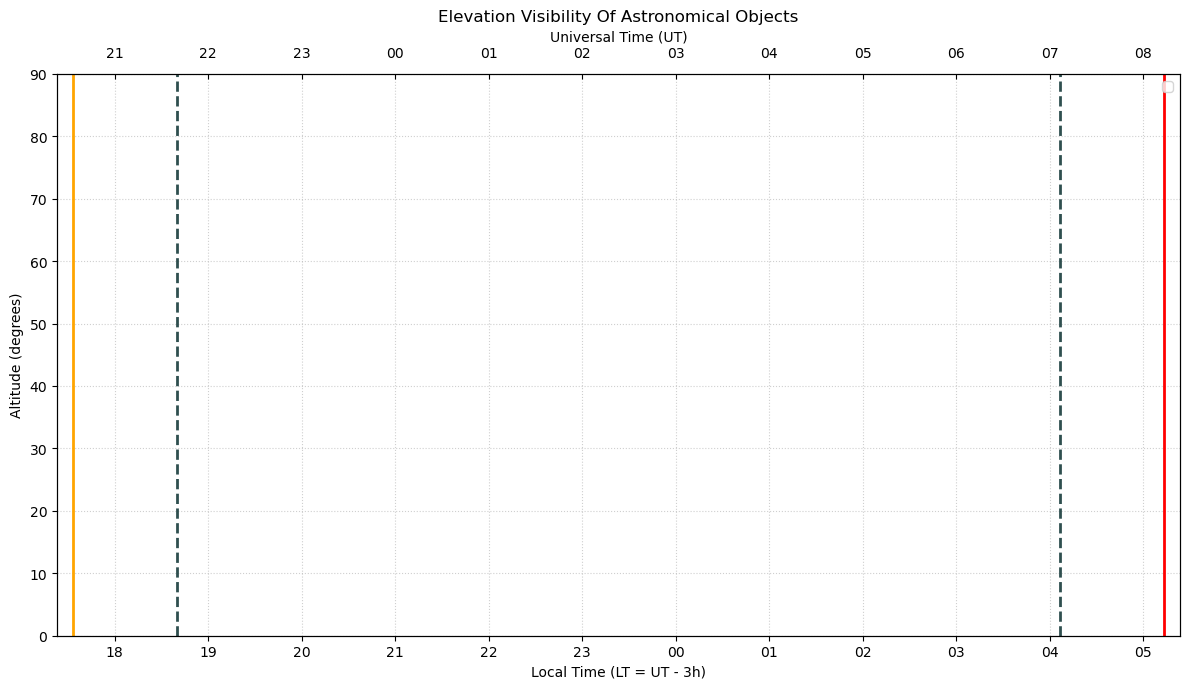

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# --- 1. Define the Time Data and UT Offset ---
# The UTC Offset (e.g., Local Time = UTC - 3 hours)
UT_OFFSET = -3 # hours. Change this to your actual offset.

# Placeholder date for the 'current' day (Oct 2, 2025)
today = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
tomorrow = today + timedelta(days=1)

def parse_time(time_str, base_date):
    """Parses 'HH:MM:SS.ms' string and combines with a base date."""
    H, M, S = map(float, time_str.split(':'))
    seconds_int = int(S)
    microseconds = int((S - seconds_int) * 1000000)
    
    return base_date.replace(
        hour=int(H), 
        minute=int(M), 
        second=seconds_int, 
        microsecond=microseconds
    )

# Local Time (LT) data points
SUNSET = parse_time(maped.decimal_hours_to_time(sunset_1), today)
twilight_dusk = parse_time(maped.decimal_hours_to_time(dusk_1), today)
twilight_dawn = parse_time(maped.decimal_hours_to_time(dawn_2), tomorrow)
SUNRISE = parse_time(maped.decimal_hours_to_time(sunrise_2), tomorrow)

all_events = [SUNSET, twilight_dusk, twilight_dawn, SUNRISE]

# --- 2. Create the Primary Plot (Local Time) ---
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the vertical lines
ax.axvline(SUNSET, color='orange', linestyle='-', linewidth=2, label='Sunset')
ax.axvline(twilight_dusk, color='darkslategray', linestyle='--', linewidth=2, label='Twilight Dusk')
ax.axvline(twilight_dawn, color='darkslategray', linestyle='--', linewidth=2, label='Twilight Dawn')
ax.axvline(SUNRISE, color='red', linestyle='-', linewidth=2, label='Sunrise')




# Set y-axis and limits
ax.set_yticks([0,10,20,30,40,50,60,70,80,90])
ax.set_ylim(0, 90)

# Set the x-axis limits
start_time = min(all_events) - timedelta(minutes=10)
end_time = max(all_events) + timedelta(minutes=10)
ax.set_xlim(start_time, end_time)

# Local Time (LT) formatting
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

if UT_OFFSET <= 0:
    ax.set_xlabel(f"Local Time (LT = UT - {abs(UT_OFFSET)}h)")
else:
    ax.set_xlabel(f"Local Time (LT = UT + {abs(UT_OFFSET)}h)")


ax.set_ylabel("Altitude (degrees)")
ax.grid(axis='x', linestyle=':', alpha=0.6) # Optional: Add grid for better readability
ax.grid(axis='y', linestyle=':', alpha=0.6) # Optional: Add grid for better readability


# --- 3. Create the Twin X-Axis for UTC Time (The Solution) ---

# Create a twin axis that shares the same y-axis
ax2 = ax.twiny() 


# ax2.plot(list_dates_objects_modified,list_altitude_degrees,label='Object 1')
# The key step: Set the limits of ax2 to be shifted by the UT_OFFSET
# LT_start - UT_OFFSET = UT_start
ax2.set_xlim(ax.get_xlim()) 

# --- Formatting the UTC Axis ---

# To display UTC hours, we apply the inverse shift to the formatter.
# The formatter function receives the LT value (e.g., 20.0), 
# but we want it to display the UT value (20.0 + 3 hours = 23.0).
def utc_formatter(x, pos):
    """
    Custom formatter function to display UTC hour.
    x is the plot coordinate (LT), which we interpret as a datetime object.
    We shift the time by UT_OFFSET and return the hour component.
    """
    # Convert the plot coordinate (Matplotlib date number) back to datetime object
    dt = mdates.num2date(x)
    
    # Calculate the corresponding UTC time
    utc_dt = dt - timedelta(hours=UT_OFFSET)
    
    # Return the formatted hour as a string
    return utc_dt.strftime('%H')

# Apply the same hourly locator
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))

# Apply the custom UTC formatter
ax2.xaxis.set_major_formatter(plt.FuncFormatter(utc_formatter))

# Set the label for the new axis
ax2.set_xlabel("Universal Time (UT)", fontsize=10)

# Adjust the location of the twin axis ticks (optional, but good for separation)
ax2.tick_params(axis='x', direction='in', pad=10)


plt.title("Elevation Visibility Of Astronomical Objects")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

C:\Users\michi\AppData\Local\Temp\ipykernel_2488\243870874.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


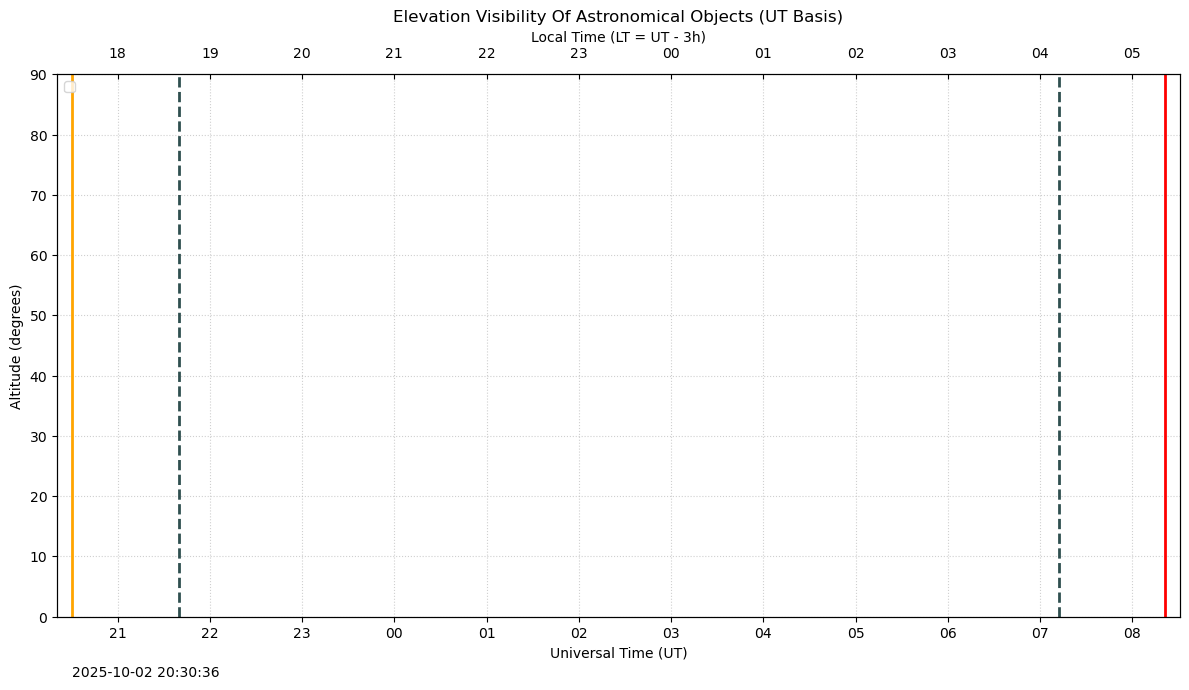

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# --- 1. Define the Time Data and UT Offset ---
# The UTC Offset (e.g., Local Time = UTC - 3 hours)
# NOTE: Using a hypothetical UT_OFFSET = -3 for this example.
# Ensure 'date_str', 'maped.decimal_hours_to_time', 'sunset_1', etc., are defined in your environment.
UT_OFFSET = -3 # hours. Change this to your actual offset.

# Placeholder date for the 'current' day (Oct 2, 2025)
# Using a dummy date_str and time values for the purpose of a runnable example
date_str = "2025-10-02 12:00:00"
today = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
tomorrow = today + timedelta(days=1)

# Dummy implementation for required external functions/variables
class Maped:
    @staticmethod
    def decimal_hours_to_time(h):
        h_int = int(h)
        m = int((h - h_int) * 60)
        s = int(((h - h_int) * 60 - m) * 60)
        return f"{h_int:02d}:{m:02d}:{s:02d}.00"

maped = Maped()
sunset_1 = 17.51
dusk_1 = 18.67
dawn_2 = 4.2
sunrise_2 = 5.35

def parse_time(time_str, base_date):
    """Parses 'HH:MM:SS.ms' string and combines with a base date."""
    H, M, S = map(float, time_str.split(':'))
    seconds_int = int(S)
    microseconds = int((S - seconds_int) * 1000000)
    
    return base_date.replace(
        hour=int(H), 
        minute=int(M), 
        second=seconds_int, 
        microsecond=microseconds
    )

# 1a. Calculate Local Time (LT) data points
LT_SUNSET = parse_time(maped.decimal_hours_to_time(sunset_1), today)
LT_twilight_dusk = parse_time(maped.decimal_hours_to_time(dusk_1), today)
LT_twilight_dawn = parse_time(maped.decimal_hours_to_time(dawn_2), tomorrow)
LT_SUNRISE = parse_time(maped.decimal_hours_to_time(sunrise_2), tomorrow)

# 1b. ***CRUCIAL STEP: Convert LT events to UT events***
# UT = LT - UT_OFFSET
UT_SUNSET = LT_SUNSET - timedelta(hours=UT_OFFSET)
UT_twilight_dusk = LT_twilight_dusk - timedelta(hours=UT_OFFSET)
UT_twilight_dawn = LT_twilight_dawn - timedelta(hours=UT_OFFSET)
UT_SUNRISE = LT_SUNRISE - timedelta(hours=UT_OFFSET)

# The data to be plotted (UT)
all_events_ut = [UT_SUNSET, UT_twilight_dusk, UT_twilight_dawn, UT_SUNRISE]


# --- 2. Create the Primary Plot (Now representing UT) ---
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the vertical lines using the UT events
ax.axvline(UT_SUNSET, color='orange', linestyle='-', linewidth=2, label='Sunset')
ax.axvline(UT_twilight_dusk, color='darkslategray', linestyle='--', linewidth=2, label='Twilight Dusk')
ax.axvline(UT_twilight_dawn, color='darkslategray', linestyle='--', linewidth=2, label='Twilight Dawn')
ax.axvline(UT_SUNRISE, color='red', linestyle='-', linewidth=2, label='Sunrise')


# Set y-axis and limits
ax.set_yticks([0,10,20,30,40,50,60,70,80,90])
ax.set_ylim(0, 90)


# Text sunset sunrise 
ax.text(UT_SUNSET,-10,str(UT_SUNSET))

# Set the x-axis limits based on the UT events
start_time_ut = min(all_events_ut) - timedelta(minutes=10)
end_time_ut = max(all_events_ut) + timedelta(minutes=10)
ax.set_xlim(start_time_ut, end_time_ut)

# --- Primary X-Axis (Bottom): Universal Time (UT) ---
# Since the data being plotted (UT_SUNSET, etc.) is already in UT, 
# we can use the standard DateFormatter.
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# Set the main axis label to UT
ax.set_xlabel("Universal Time (UT)")
ax.set_ylabel("Altitude (degrees)")
ax.grid(axis='x', linestyle=':', alpha=0.6)
ax.grid(axis='y', linestyle=':', alpha=0.6)


# --- 3. Create the Twin X-Axis (Top): Local Time (LT) ---

# Create a twin axis that shares the same y-axis
ax2 = ax.twiny() 
ax2.set_xlim(ax.get_xlim()) 

# --- Formatting the Local Time (LT) Axis ---

def lt_formatter(x, pos):
    """
    Custom formatter function to display Local Time (LT) hour.
    x is the plot coordinate (UT time number).
    LT = UT + UT_OFFSET. We shift the time by +UT_OFFSET.
    """
    # Convert the plot coordinate (Matplotlib date number) back to datetime object (UT time)
    dt_ut = mdates.num2date(x)
    
    # Calculate the corresponding Local Time
    dt_lt = dt_ut + timedelta(hours=UT_OFFSET)
    
    # Return the formatted hour as a string
    return dt_lt.strftime('%H')

# Apply the same hourly locator
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))

# Apply the custom LT formatter
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lt_formatter))

# Set the label for the new axis to LT
if UT_OFFSET <= 0:
    ax2.set_xlabel(f"Local Time (LT = UT - {abs(UT_OFFSET)}h)", fontsize=10)
else:
    ax2.set_xlabel(f"Local Time (LT = UT + {abs(UT_OFFSET)}h)", fontsize=10)

# Adjust the location of the twin axis ticks
ax2.tick_params(axis='x', direction='in', pad=10)


plt.title("Elevation Visibility Of Astronomical Objects (UT Basis)")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# import datetime

# datetime_object = datetime.datetime(2024, 3, 14, 15, 30, 0)

# format_string = '%Y-%m-%d %H:%M:%S'


# date_string = "2025-09-25 14:30:00"
# date_object = datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S")


# date_object_1 = date_object + timedelta(days=1)
# date_object_1.strftime("%Y-%m-%d %H:%M:%S")



'2025-09-26 14:30:00'

In [22]:
# Assuming you are planning for the night of 2025-10-03 to 2025-10-04
DATE_3 = "2005-03-03 00:00:00"

DATE_3_object = datetime.strptime(DATE_3, "%Y-%m-%d %H:%M:%S")
DATE_4_object = DATE_3_object + timedelta(days=1)

DATE_4 = DATE_4_object.strftime("%Y-%m-%d %H:%M:%S")  # "2025-10-04 00:00:00"

# Fixed site and UT offset for this example
site_longitude_360 = 244.536 # e.g. from the image
site_latitude = 31.0442
ut_offset = -8.0 # Example UT offset for Chile
elevation_m = 2830 

def calculate_events_for_date(date_str, site_lon, site_lat, ut_off, elevation):
    # 1. Parse Date and Calculate JD
    Y, M, D = maped.parse_date_to_YMD_flexible(date_str)
    JD = maped.calculate_julian_day(Y, M, D)
    
    # 2. Calculate Delta T for high precision
    delta_t_seconds = maped.calculate_delta_t(Y, M)
    
    # 3. Calculate all events for this single date
    sunrise, sunset, dawn, dusk = maped.calculate_sunrise_sunset_twilight_simple(
        JD, 
        site_lon, 
        site_lat, 
        ut_off,
        elevation,         
        delta_t_seconds
    )
    return sunrise, sunset, dawn, dusk



In [23]:
# --- 1. Get Evening Events (Sunset & Dusk for Oct 3) ---
sunrise_3, sunset_3, dawn_3, dusk_3 = calculate_events_for_date(
    DATE_3, site_longitude_360, site_latitude, ut_offset, elevation_m
)

# --- 2. Get Morning Events (Dawn & Sunrise for Oct 4) ---
sunrise_4, sunset_4, dawn_4, dusk_4 = calculate_events_for_date(
    DATE_4, site_longitude_360, site_latitude, ut_offset, elevation_m
)

# --- Final Observation Plan Summary ---
print(f"Observation Night: {DATE_3.split(' ')[0]} to {DATE_4.split(' ')[0]}")
print(f"Sunset: {maped.decimal_hours_to_time(sunset_3)}")
print(f"Astronomical Dusk: {maped.decimal_hours_to_time(dusk_3)}")
print(f"Astronomical Dawn (Next Day): {maped.decimal_hours_to_time(dawn_4)}")
print(f"Sunrise (Next Day): {maped.decimal_hours_to_time(sunrise_4)}")

Observation Night: 2005-03-03 to 2005-03-04
Sunset: 17:50:48.00
Astronomical Dusk: 19:02:26.54
Astronomical Dawn (Next Day): 04:46:06.47
Sunrise (Next Day): 05:57:44.08


In [63]:
# Calculate SUNRISE, SUNSET, TWILIGHT_DAWN AND TWILIGHT_DUSK FOR THE STARTING DATE OF OBSERVATIONS
Y, M, D = maped.parse_date_to_YMD_flexible(date_str)
JD = maped.calculate_julian_day(Y, M, D) 

sunrise, sunset, dawn, dusk = maped.calculate_sunrise_sunset_twilight_simple(JD,site_longitude,site_latitude,ut_offset)

In [66]:
y = 2005 + (1 - 0.5)/12
t = y - 2000
delta_T = 62.92 + 0.32217 * t + 0.005589 * t**2
delta_T

64.68633720312503

In [54]:
# ΔT = -20 + 32 * t^2 seconds
# 			where:	t = (year-1820)/100
y = Y + (M - 0.5)/12
t = (y-1820)/100
delta_T = -20 + 32 * t**2
delta_T

114.64405

In [3]:
# Calculate SUNRISE, SUNSET, TWILIGHT_DAWN AND TWILIGHT_DUSK FOR THE STARTING DATE OF OBSERVATIONS
Y_START, M_START, D_START = maped.parse_date_to_YMD_flexible(date_str)
JD_START = maped.calculate_julian_day(Y_START, M_START, D_START) 
# Calculate Delta T using the new function
delta_t_seconds = maped.calculate_delta_t(Y_START, M_START) # This will be ~69.7 seconds

sunrise_START, sunset_START, dawn_START, dusk_START = maped.calculate_sunrise_sunset_twilight_simple(JD_START-1,site_longitude,site_latitude,ut_offset,site_elevation,delta_t_seconds)

print(maped.decimal_hours_to_time(sunrise_START),maped.decimal_hours_to_time(sunset_START),maped.decimal_hours_to_time(dawn_START),maped.decimal_hours_to_time(dusk_START))


# Calculate SUNRISE, SUNSET, TWILIGHT_DAWN AND TWILIGHT_DUSK FOR THE FOLLOWING DATE OF OBSERVATIONS
JD_NEXT = JD_START
sunrise_NEXT, sunset_NEXT, dawn_NEXT, dusk_NEXT = maped.calculate_sunrise_sunset_twilight_simple(JD_NEXT,site_longitude,site_latitude,ut_offset,site_elevation,delta_t_seconds)

print(maped.decimal_hours_to_time(sunrise_NEXT),maped.decimal_hours_to_time(sunset_NEXT),maped.decimal_hours_to_time(dawn_NEXT),maped.decimal_hours_to_time(dusk_NEXT))


05:30:31.12 18:04:47.72 04:19:58.19 19:15:20.65
05:30:54.35 18:04:46.08 04:20:29.10 19:15:11.34


In [4]:
SUNSET = maped.decimal_hours_to_time(sunset_START-ut_offset)
twilight_dusk = maped.decimal_hours_to_time(dusk_START-ut_offset)
SUNRISE = maped.decimal_hours_to_time(sunrise_NEXT-ut_offset)
twilight_dawn = maped.decimal_hours_to_time(dawn_NEXT-ut_offset)
print('sunset: ',SUNSET,' dusk: ',twilight_dusk,' dawn: ',twilight_dawn,' sunrise: ',SUNRISE)

sunset:  21:04:47.72  dusk:  22:15:20.65  dawn:  07:20:29.10  sunrise:  08:30:54.35
